In [2]:
import pandas as pd
import sklearn
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

function name: pre_cleansing

Description:

The function cleans the match statistics data and removes the ones that have low to no information for a given match。

Input:

1. Match_stats [DataFrame]: It includes all the players' information for all matches of a given year.

Output:

1. Match_stats_sanitized [DataFrame]: It includes the cleaned data.

In [3]:
def data_pre_cleansing(Match_stats):    
    drop_list =[]
    hero = Match_stats.loc[0,'hero']
    flag = False

    # Delete range
    range_begin = 0
    range_end = 0

    for index, row in Match_stats.iterrows():
        # If Alive Time < 30 sec
        if(row.stat_name == 'Time Alive'):
            if(row.stat_amount < 30):
                flag = True
        if(row.stat_name == 'Time Played'):
            if(row.stat_amount < 30):
                flag = True        

        if(row.hero!= hero):
            hero = row.hero
            range_end = index-1

        # If stat less than 6
            if((range_end-range_begin+1)< 6): 
                flag = True

            if(flag):
                # print(range_begin,'-',range_end)
                drop_list.append((range_begin,range_end))
            range_begin = index
            flag = False
        if index == Match_stats.index[-1]:
            if(flag):
                print(range_begin,'-',index)
                drop_list.append((range_begin,index))
    return drop_list

def drop_data(list,data):
    full_drop_list = []
    for pair in list:
        for x in range(pair[0],pair[1]): 
            full_drop_list.append(x)
    return data.drop(full_drop_list,axis=0)

def pre_cleansing(Match_stats):
    drop_list = data_pre_cleansing(Match_stats)
    return drop_data(drop_list,Match_stats) 

In [4]:
phs_2019 = pd.read_csv('phs_2019_playoffs.csv')
phs_2020_1 = pd.read_csv('phs_2020_1.csv')
phs_2020_2 = pd.read_csv('phs_2020_2.csv')

In [5]:
def cleaning_aft(csv_before):
    csv_before = pre_cleansing(csv_before) 
    csv_before.drop(columns=['start_time','stage','map_type'],inplace=True)
    csv_before.drop(csv_before[(csv_before.hero == "All Heroes")].index, inplace=True) 
    return csv_before

In [12]:
phs_2020_1 = phs_2020_1.rename(columns={"hero_name": "hero"})
phs_2020_2 = phs_2020_2.rename(columns={"hero_name": "hero"})

In [13]:
clean_df_2019 = cleaning_aft(phs_2019)
clean_df_2020_1 = cleaning_aft(phs_2020_1)
clean_df_2020_2 = cleaning_aft(phs_2020_2)

760104 - 760110


KeyError: ignored

In [ ]:
frames = [clean_df_2019, clean_df_2020_1,clean_df_2020_2]
total_data = pd.concat(frames)
total_data

,match_id,map_name,player,team,stat_name,hero,stat_amount
28,30172,Ilios,Elsa,Chengdu Hunters,All Damage Done,D.Va,13934.906430
29,30172,Ilios,Elsa,Chengdu Hunters,Assists,D.Va,15.000000
30,30172,Ilios,Elsa,Chengdu Hunters,Average Time Alive,D.Va,569.509017
31,30172,Ilios,Elsa,Chengdu Hunters,Barrier Damage Done,D.Va,6703.071256
32,30172,Ilios,Elsa,Chengdu Hunters,Critical Hit Accuracy,D.Va,0.092603
...,...,...,...,...,...,...,...
473159,35552,Hollywood,tobi,Seoul Dynasty,Time Played,Mercy,919.875289
473160,35552,Hollywood,tobi,Seoul Dynasty,Ultimates Earned - Fractional,Mercy,4.811592
473161,35552,Hollywood,tobi,Seoul Dynasty,Ultimates Used,Mercy,4.000000
473162,35552,Hollywood,tobi,Seoul Dynasty,Valkyrie Healing Efficiency,Mercy,301.680441


In [ ]:
def cal_contribution(total_data):
  contribution = []
  temp_data = total_data[total_data['stat_name'] == 'Time Played']
  a = temp_data.groupby(by=['match_id','map_name','team']).sum()
  b = temp_data.groupby(by=['match_id','map_name','team','hero']).sum()
  for row in total_data.iterrows():
    match_id = row[1]['match_id']
    team = row[1]['team']
    map_name = row[1]['map_name']
    hero_name = row[1]['hero']
    try:
      total_time = a.loc[match_id].loc[map_name,team].iloc[0]
    except:
      print('total_time:' + str(match_id) + map_name+ team + hero_name)
    try:
      hero_time = b.loc[match_id,map_name].loc[team,hero_name].iloc[0]
    except:
      print('hero_time:' + str(match_id)  + map_name + team + hero_name)
    contribution.append(hero_time/total_time)
  total_data['contribution']=contribution
  return total_data

In [ ]:
total_data = cal_contribution(total_data)

In [ ]:
total_data.hero.unique()

array(['D.Va', 'Sigma', 'Doomfist', 'Junkrat', 'Pharah', 'Lúcio', 'Moira',
       'Sombra', 'Symmetra', 'Baptiste', 'Mercy', 'Orisa',
       'Wrecking Ball', 'Zarya', 'Reaper', 'Tracer', 'Ana', 'Winston',
       'McCree', 'Widowmaker', 'Ashe', 'Mei', 'Hanzo', 'Bastion',
       'Brigitte', 'Reinhardt', 'Zenyatta', 'Roadhog', 'Genji',
       'Soldier: 76', 'Torbjörn', 'Echo'], dtype=object)

In [ ]:
# number of different match_id
print('number of different match_id:', total_data.match_id.nunique())

number of different match_id: 336


In [ ]:
# number of records in each match_id
total_data.match_id.value_counts()

30175    6709
34516    5979
34515    5331
34620    5102
34502    4924
         ... 
36205      54
36201      54
36202      39
36197      38
36221      37
Name: match_id, Length: 336, dtype: int64

In [ ]:
match_result = pd.read_csv('annual_match_result_table.csv')
match_result

,match_year,match_id,map_name,map_winner,winning_team_final_map_score,winning_team_win_rate,map_loser,losing_team_final_map_score,losing_team_win_rate
0,2018,10223,Dorado,Los Angeles Valiant,3,0.600000,San Francisco Shock,2,0.400000
1,2018,10223,Temple of Anubis,Los Angeles Valiant,4,0.571429,San Francisco Shock,3,0.428571
2,2018,10223,Ilios,Los Angeles Valiant,2,0.666667,San Francisco Shock,1,0.333333
3,2018,10223,Numbani,Los Angeles Valiant,2,0.666667,San Francisco Shock,1,0.333333
4,2018,10224,Dorado,Los Angeles Gladiators,1,1.000000,Shanghai Dragons,0,0.000000
...,...,...,...,...,...,...,...,...,...
4511,2021,37442,Dorado,Atlanta Reign,3,0.600000,Dallas Fuel,2,0.400000
4512,2021,37441,Ilios,Shanghai Dragons,2,1.000000,Atlanta Reign,0,0.000000
4513,2021,37441,Hanamura,Shanghai Dragons,3,0.600000,Atlanta Reign,2,0.400000
4514,2021,37441,King's Row,Shanghai Dragons,6,0.545455,Atlanta Reign,5,0.454545


In [ ]:
def clean_match(hero_name, match_info):
    clean_match_df = match_info.merge(match_result.iloc[:, :6], how = 'inner', left_on =['match_id', 'map_name', 'team'], right_on =['match_id', 'map_name', 'map_winner'])
    hero_info = clean_match_df[clean_match_df['hero'] == hero_name]
    if len(hero_info) == 0:
        return 'No record about the hero name: ' + hero_name
    else:
        return hero_info

In [ ]:
Top_11_stat_name = list(clean_df_2019.stat_name.value_counts()[:11].index)
Top_11_stat_name

['Ultimates Earned - Fractional',
 'Time Played',
 'Time Building Ultimate',
 'Time Elapsed per Ultimate Earned',
 'Time Alive',
 'Damage Taken',
 'Healing Received',
 'All Damage Done',
 'Hero Damage Done',
 'Average Time Alive',
 'Barrier Damage Done']

In [ ]:
# Top 11 stat_name in year 2019 
clean_df_2019.stat_name.value_counts()[:11]

Ultimates Earned - Fractional       2078
Time Played                         1789
Time Building Ultimate              1787
Time Elapsed per Ultimate Earned    1781
Time Alive                          1781
Damage Taken                        1779
Healing Received                    1775
All Damage Done                     1758
Hero Damage Done                    1755
Average Time Alive                  1715
Barrier Damage Done                 1702
Name: stat_name, dtype: int64

In [ ]:
def prepare_data(data_set):
   data_set = data_set[data_set.stat_name.isin(Top_11_stat_name)].iloc[:, [0,1, 4, 6, 10]]
   data_set = pd.pivot_table(data_set, values = ['stat_amount'], index = ['match_id', 'map_name','winning_team_win_rate'], columns = ['stat_name'])
   data_set = data_set.apply(lambda x: x.fillna(x.mean())) 
   return data_set

stat_amount  \
stat_name                                            All Damage Done   
match_id map_name              winning_team_win_rate                   
30151    Lijiang Tower         0.666667                    30.000000   
30152    Rialto                0.666667                   237.013041   
30153    Numbani               0.571429                   237.013041   
         Watchpoint: Gibraltar 0.666667                   237.013041   
30154    Rialto                0.600000                    40.000000   
...                                                              ...   
35553    Oasis                 1.000000                   180.000000   
         Volskaya Industries   0.666667                   981.036463   
35554    Busan                 1.000000                   230.000000   
         King's Row            0.600000                   429.636252   
         Temple of Anubis      0.571429                   783.249207   

                                                                         \
stat_name                                            Average Time Alive   
match_id map_name              winning_team_win_rate                      
30151    Lijiang Tower         0.666667                       65.852502   
30152    Rialto                0.666667                      116.879003   
30153    Numbani               0.571429                      330.855010   
         Watchpoint: Gibraltar 0.666667                      243.327007   
30154    Rialto                0.600000                       41.419001   
...                                                                 ...   
35553    Oasis                 1.000000                       98.012253   
         Volskaya Industries   0.666667                      128.683604   
35554    Busan                 1.000000                      126.537254   
         King's Row            0.600000                      256.239674   
         Temple of Anubis      0.571429                      124.976504   

                                                                          \
stat_name                                            Barrier Damage Done   
match_id map_name              winning_team_win_rate                       
30151    Lijiang Tower         0.666667                        86.381931   
30152    Rialto                0.666667                        86.381931   
30153    Numbani               0.571429                        86.381931   
         Watchpoint: Gibraltar 0.666667                        86.381931   
30154    Rialto                0.600000                        86.381931   
...                                                                  ...   
35553    Oasis                 1.000000                        86.381931   
         Volskaya Industries   0.666667                        60.000000   
35554    Busan                 1.000000                        30.000000   
         King's Row            0.600000                        20.000000   
         Temple of Anubis      0.571429                        86.381931   

                                                                   \
stat_name                                            Damage Taken   
match_id map_name              winning_team_win_rate                
30151    Lijiang Tower         0.666667                521.445948   
30152    Rialto                0.666667                409.086268   
30153    Numbani               0.571429                507.793194   
         Watchpoint: Gibraltar 0.666667                 61.050000   
30154    Rialto                0.600000                223.880165   
...                                                           ...   
35553    Oasis                 1.000000               1530.619066   
         Volskaya Industries   0.666667               2226.609806   
35554    Busan                 1.000000               1220.128533   
         King's Row            0.600000               1042.668740   
         Temple of Anubis      0.57

There are 11 common stat_name with the highly appearance frequency. we will use these 11 stat_names to do analysis to see the relationhsip between each of them and the winning rate

In [ ]:
def regression(hero,stat_name):
    data = clean_match(hero,total_data)
    data_set = prepare_data(data)
    winning_rate = data_set.index.get_level_values(2).to_numpy().reshape(-1, 1)
    play_time = data_set.iloc[:, data_set.columns.get_level_values(1)=='Time Played'].values
    stat = data_set.iloc[:, data_set.columns.get_level_values(1)== stat_name].values.reshape(-1, 1)/play_time
    stat[stat == stat.max()] = stat.mean()
    stat[stat == stat.max()] = stat.mean()
    stat[stat == stat.min()] = stat.mean()
    return stat,winning_rate


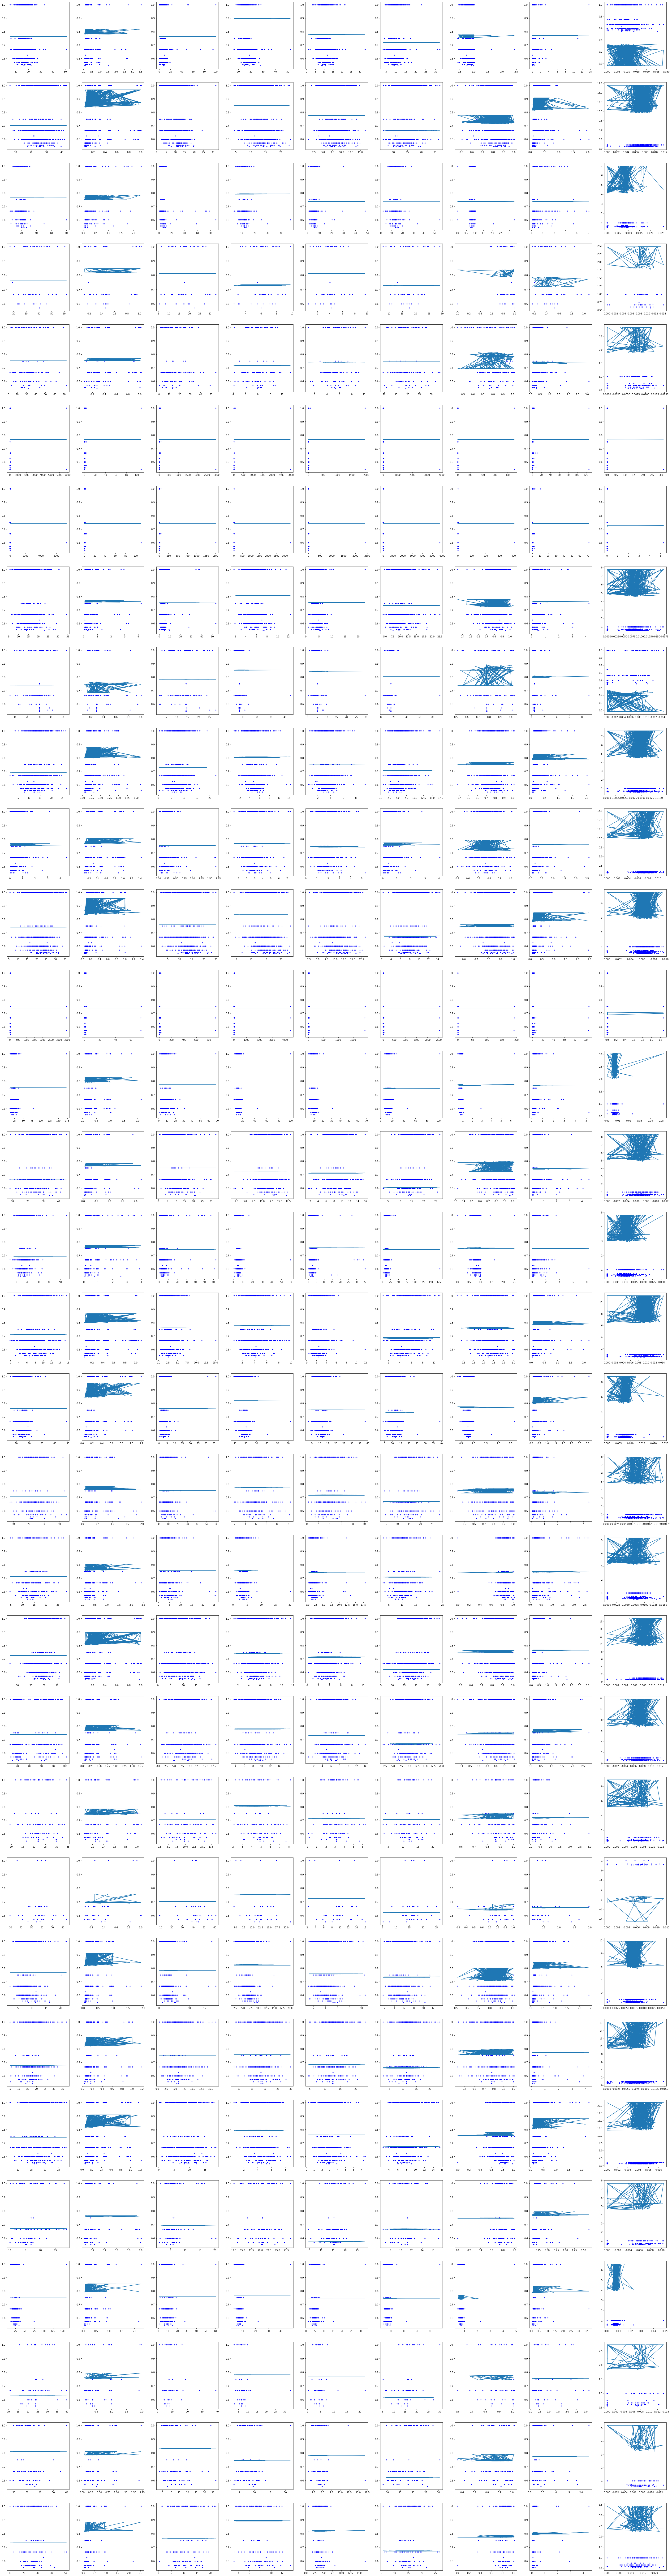

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

hero_list = ['D.Va', 'Sigma', 'Doomfist', 'Junkrat', 'Pharah', 'Lúcio', 'Moira','Sombra', 'Symmetra', 'Baptiste', 'Mercy', 'Orisa','Wrecking Ball', 'Zarya', 'Reaper', 'Tracer', 'Ana', 'Winston','McCree', 'Widowmaker', 'Ashe', 'Mei', 'Hanzo', 'Bastion','Brigitte', 'Reinhardt', 'Zenyatta', 'Roadhog', 'Genji','Soldier: 76', 'Torbjörn', 'Echo']
stat_list = ['All Damage Done','Average Time Alive','Barrier Damage Done','Damage Taken','Healing Received','Hero Damage Done','Time Building Ultimate','Time Elapsed per Ultimate Earned','Ultimates Earned - Fractional']
x = 0
y = 0

fig, axs = plt.subplots(32,9,figsize=(50,200)) 
for hero in hero_list:
       for stat in stat_list:
              result = regression(hero,stat)
              stat = result[0]
              winning_rate = result[1]
              model.fit(stat,winning_rate)
              # print(model.score(stat,winning_rate))
       
              
              axs[y,x].plot(stat,winning_rate,'b.')
              axs[y,x].plot(stat,model.predict(winning_rate))
              x = x+1
       x = 0
       y = y+1
plt.show()
           